### This is the version with trace + title + processed text

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import random as rn
from sklearn.metrics import confusion_matrix
import seaborn as sns


import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score

nltk.download("wordnet")
nltk.download("punkt")

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Haochen_Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Haochen_Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data = pd.read_csv("Metadata Labeled.csv")
np.random.seed(12)
rn.seed(12)
tf.random.set_seed(12)

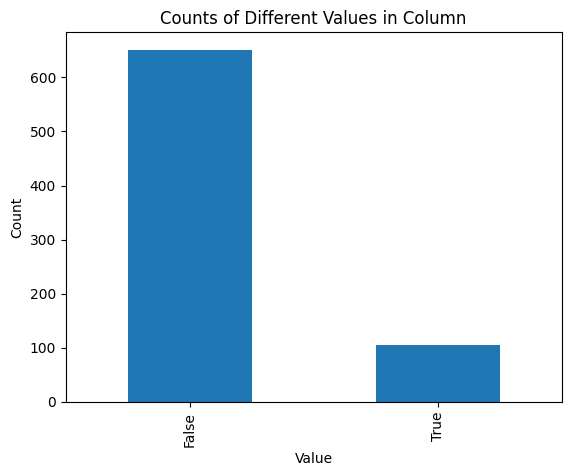

In [4]:
# imblance
column_data = data['Good']

value_counts = column_data.value_counts()

value_counts.plot(kind='bar')

plt.title('Counts of Different Values in Column')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [5]:
class TraceCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["Trace"] = X["Trace"].str.replace(r'\W+', ' ', regex=True)
        X["Title"] = X["Title"].str.replace(r'\W+', ' ', regex=True)
        X["Processed Text"] = X["Processed Text"].apply(self.lemmatize_text)
        return X

    def lemmatize_text(self, text):
        words = nltk.word_tokenize(text)
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmatized_words)

In [6]:
def preprocess_data(X_train, X_test):
    max_words = 10000
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train["Trace"] + " " + X_train["Title"] + " " + X_train["Processed Text"])

    X_train = tokenizer.texts_to_sequences(X_train["Trace"] + " " + X_train["Title"] + " " + X_train["Processed Text"])
    X_test = tokenizer.texts_to_sequences(X_test["Trace"] + " " + X_test["Title"] + " " + X_test["Processed Text"])

    max_len = 100
    X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
    X_test = pad_sequences(X_test, maxlen=max_len, padding="post")

    return X_train, X_test

In [7]:
def build_gru_model(embedding_dim=64, gru_units=32):
    max_words = 10000
    max_len = 100

    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        GRU(gru_units),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [8]:
trace_cleaner = TraceCleaner()
data = trace_cleaner.fit_transform(data)

y = data["Good"]

# 80% train set, 20% test set with stratified sampling
train_data, test_data = train_test_split(data, test_size=0.2, random_state=12, stratify=y)

# preprocess_data
X_train, X_test = preprocess_data(train_data, test_data)

y_train = train_data["Good"].values
y_test = test_data["Good"].values

In [9]:
class KerasClassifierWithWeight(KerasClassifier):
    def fit(self, X, y, **kwargs):
        if "class_weight" in kwargs:
            class_weight = kwargs["class_weight"]
            kwargs.pop("class_weight")
        else:
            class_weight = None
        return super().fit(X, y, class_weight=class_weight, **kwargs)

In [10]:
# model and pipeline
model = KerasClassifierWithWeight(model=build_gru_model, epochs=10, batch_size=32, verbose=0, embedding_dim=64, gru_units=32)
pipeline = Pipeline([("model", model)])

In [11]:
# hyperparameters
param_grid = {
    "model__embedding_dim": [8,16, 32, 64],
    "model__gru_units": [8,16,32,64,128],
    "model__class_weight": [{0: 1, 1: weight} for weight in np.arange(1.0, 10.0, 1.0)]
}

In [12]:
# cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="accuracy", verbose=1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best hyperparameters found:  {'model__class_weight': {0: 1, 1: 5.0}, 'model__embedding_dim': 64, 'model__gru_units': 32}


In [13]:
y_test_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=True)
test_recall = recall_score(y_test, y_test_pred, pos_label=True)
test_f1 = f1_score(y_test, y_test_pred, pos_label=True)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test F1 score: {test_f1:.4f}")

Test accuracy: 0.9408
Test precision: 0.9286
Test recall: 0.6190
Test F1 score: 0.7429


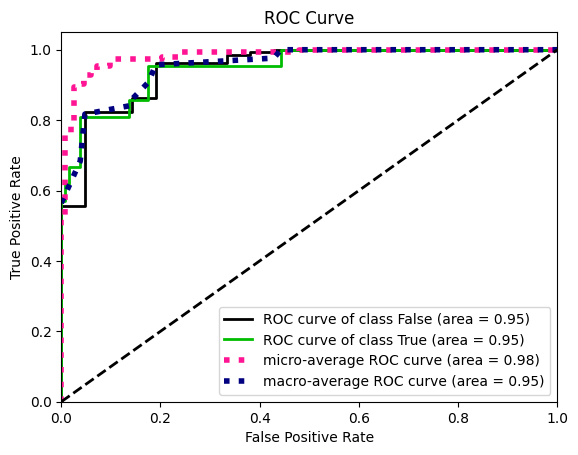

In [14]:
y_pred_proba_test = grid_search.predict_proba(X_test)

# ROC curve
skplt.metrics.plot_roc(y_test, y_pred_proba_test)
plt.title('ROC Curve')
plt.show()

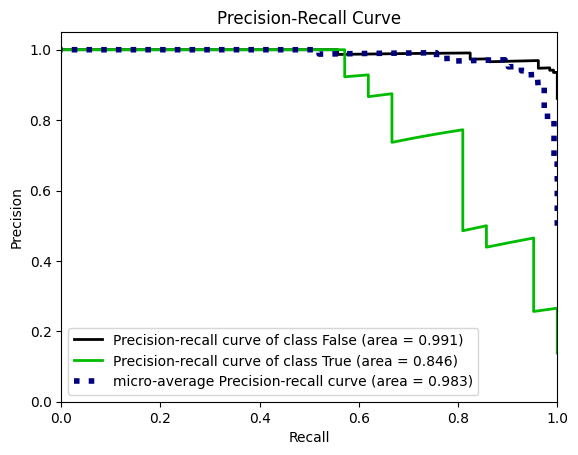

In [15]:
# Precision-Recall curve
skplt.metrics.plot_precision_recall(y_test, y_pred_proba_test)
plt.title('Precision-Recall Curve')
plt.show()

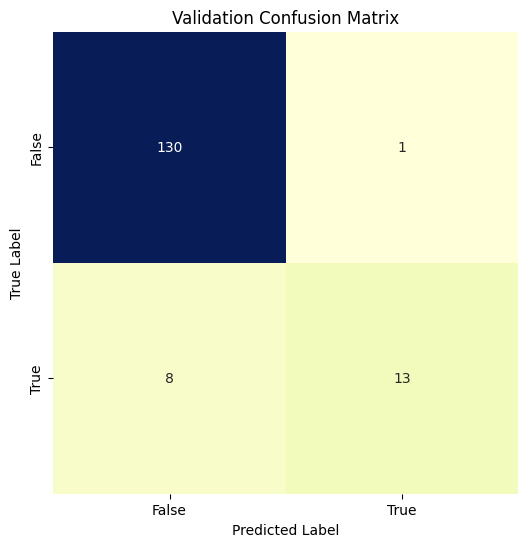

In [16]:
# validation confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False, xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix")
plt.show()